# Hessian-based toolbox for more reliable and interpretable machines learning physics

The aim of this Jupyter Notebook is to give a ready-to-use code of the Hessian-based toolbox which increases the reliability and interpretability of pre-trained ML models. We described this toolbox in the paper 'Hessian-based toolbox for more reliable and interpretable machines learning physics' by A. Dawid, P. Huembeli, M. Tomza, M. Lewenstein, and A. Dauphin (collaboration of ICFO, Spain and University of Warsaw, Poland) available at [arXiv](https://arxiv.org/abs/?). We will analyze here the CNN trained to recognize phases in the 1D spinless Fermi-Hubbard model.

The scope of the notebook is the following:

1. Loading a data set (in our case, the transition line of the 1D spinless Fermi-Hubbard, marked with (1) in the figure below)

2. Loading a trained ML model and the Hessian of the training loss function at the model parameters corresponding to the training loss landscape minimum. You can calculate the Hessian with [this notebook](https://doi.org/10.5281/zenodo.3759432).

3. Calculation of [influence functions](http://proceedings.mlr.press/v70/koh17a.html), [RelatIFs](https://proceedings.mlr.press/v108/barshan20a), [Resampling Uncertainty Estimation (RUE)](https://proceedings.mlr.press/v89/schulam19a), and [Extrapolation Score with Local Ensembles (LEs)](https://openreview.net/forum?id=BJl6bANtwH).

4. Produce figures

<img src="./phase_diagram.png" width=800/>

## Note!
All interpretability and reliability methods, implemented here, are contributions of other amazing people. We implement them here in PyTorch and we calculate them exactly, but there are ways of approximating the Hessian and approximating the toolbox. See our paper and papers cited above to find out!

## Part 1: Load data

We have computed the ground states of the 1D spinless Fermi-Hubbard model for $V_2/J=0$ and between 0-40 $V_1/J$. You can reproduce these data using [this notebook](https://doi.org/10.5281/zenodo.3759432). We have 1000 training, 200 validation, and 50 test examples.

In [2]:
import torch
import numpy as np
from data_loader import Downloader

training_set_size = 1000
batch_size = training_set_size
test_set_size = 50 #45 or 50
chosen_test_examples = np.arange(test_set_size)

input_size = 924   # Fock basis size for 12-site problem
data_name = 'CDW_ED_size12_full' 
CDW_data = Downloader(data_name, batch_size)
train_loader = CDW_data.train_loader()
test_loader = CDW_data.test_loader(batch_size=test_set_size)
print("Data loaded.")

Data loaded.


## Part 2: Load trained model and its Hessian
We trained our CNN with SGD with momentum and with decreasing learning rate, with $L_2$ regularization. The architecture is the following (length scale doesn't apply):

<img src="./CNN_architecture.png" width=800/>

In [3]:
from architectures import CNN1D_tiny_ED
num_classes = 2
folder_model = "./model"
model_name = "Conv1D_original_l005_12site"

λ = 0.05 # Regularization
model = CNN1D_tiny_ED(num_classes)

model.load_state_dict(torch.load(folder_model + '/' + model_name + '.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
# Compute traditional test loss (using known ground-truth labels) and 'minimal' test loss (when ground-truth labels are unavailable, needed for extrapolation score)
# Save also two last neurons' outputs

import torch.nn as nn
from torch.nn import CrossEntropyLoss

criterion = nn.CrossEntropyLoss(reduction='none')
model.eval()

for eigenvectors, labels in test_loader:
    eigenvectors = eigenvectors.reshape(-1, 1, input_size) #(test_set_size, 25, 50)
    outputs = model(eigenvectors)
    neuron_0 = outputs[:,0].data
    neuron_1 = outputs[:,1].data

    _, predicted = torch.max(outputs.data, 1)
    original_test_loss = criterion(outputs, labels)
    minimal_test_loss = criterion(outputs, predicted)

    correct = (predicted == labels).sum().item()
    incorrect_mask = (predicted != labels).detach().numpy()
    
    # We manually add L2 regularization
    if λ != 0:
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param)**2
            original_test_loss += 1/training_set_size * λ/2 * l2_reg
            minimal_test_loss += 1/training_set_size * λ/2 * l2_reg

    model_accuracy = correct / len(labels)
    print("Accuracy of the model on the", len(labels), "test images:", 100 * model_accuracy, "%")
    misclassified_array = np.arange(test_set_size)[incorrect_mask]
    print("Misclassified examples: ", misclassified_array)

Accuracy of the model on the 50 test images: 88.0 %
Misclassified examples:  [21 22 23 24 25 26]


In [5]:
# Load the exact hessian
hessian = np.load(folder_model + '/' + model_name + '_hessian.npy')

## Part 3: Use the Hessian-based toolbox
We compute here:
- [influence functions](http://proceedings.mlr.press/v70/koh17a.html)
- [RelatIFs](https://proceedings.mlr.press/v108/barshan20a)
- [Resampling Uncertainty Estimation (RUE)](https://proceedings.mlr.press/v89/schulam19a)
- [Extrapolation Score with Local Ensembles (LEs)](https://openreview.net/forum?id=BJl6bANtwH)

In [6]:
from influence_function import exact_influence_functions

folder = "./toolbox_output"
folder_influence = folder + "/influence"
damping = 0.2 # needs to be larger than absolute value of the largest negative eigenvalue of the Hessian

# Influence functions and RelatIFs
exact_influence_functions(input_size, train_loader, test_loader, model, λ, hessian, damping, folder_influence, chosen_test_examples = chosen_test_examples)

Model has  740  parameters.
Smallest eigenvalues of the damped hessian:  [0.01797149 0.02008177 0.03199887 0.06747001 0.07904471]
The full Hessian got inverted.


IF (and RelatIF) computations completed.


In [7]:
from rue import calculateRUE

# RUE. "True" RUE is a version with ground-truth labels, "minimal" RUE is a version when we don't provide ground-truth labels, so we assume all predicted labels are correct.
# We do that to mimic a real-life scenario where we don't know the true labels.
folder_rue = folder + "./RUE"
rue_number_of_repetitions = 50 # how many repetitions of the bootstrap sampling do we do?

true_rue, minimal_rue = calculateRUE(input_size, train_loader, test_loader, model, λ, hessian, 1.0 + damping, number_of_repetitions = rue_number_of_repetitions, chosen_test_examples = chosen_test_examples)
np.savetxt(folder_rue + '/true_RUE.txt', true_rue)
np.savetxt(folder_rue + '/minimal_RUE.txt', minimal_rue)

Bootstrap sampling:   0%|          | 0/50 [00:00<?, ?it/s]

The full Hessian got inverted.


True variances:  [1.93205412e-05 2.12182557e-05 2.33558503e-05 2.57562588e-05
 2.84567090e-05 3.15067913e-05 3.49485940e-05 3.88283626e-05
 4.32582720e-05 4.83059871e-05 5.40442951e-05 6.05544868e-05
 6.79578128e-05 7.64104383e-05 8.64308374e-05 9.79494183e-05
 1.11160664e-04 1.26391533e-04 1.44506664e-04 1.65692026e-04
 2.02039006e-04 9.22496718e-02 7.45805429e-02 5.69711836e-02
 4.05447000e-02 2.66282254e-02 1.62366511e-02 9.43522286e-03
 5.44776957e-03 3.25163403e-03 2.05606351e-03 1.39436928e-03
 1.00559215e-03 7.65568681e-04 6.10931952e-04 5.07042621e-04
 4.33513943e-04 3.80358701e-04 3.40518319e-04 3.10814886e-04
 2.88882589e-04 2.71206959e-04 2.55858197e-04 2.40912335e-04
 2.24968087e-04 2.05463797e-04 1.84841891e-04 1.67704044e-04
 1.56752028e-04 1.50559782e-04]
Minimal variances:  [1.93205412e-05 2.12182557e-05 2.33558503e-05 2.57562588e-05
 2.84567090e-05 3.15067913e-05 3.49485940e-05 3.88283626e-05
 4.32582720e-05 4.83059871e-05 5.40442951e-05 6.05544868e-05
 6.79578128e-05 

In [8]:
from lees import calculateLEES
lees_tresholds = [1, 0.1, 0.01, 0.001] # to find optimal number of eigenvectors corresponding to positive eigenvalues, which we get rid of
folder_lees = folder + "./LEs"

# Compute extrapolation score via local ensemble for both ground-truth and minimal version
various_min_lees = []
various_true_lees = []
ms = []

for treshold in lees_tresholds:

    # Version with test loss computed by assuming that predicted labels are true labels
    print("Minimal version of LEs")
    min_lees, m = calculateLEES(input_size, test_loader, model, λ, hessian, treshold, MINIMAL_VERSION = True, chosen_test_examples = chosen_test_examples)
    various_min_lees = np.append(various_min_lees, min_lees, axis=0)
    ms = np.append(ms, m) # only once, they're independent of a version
    np.savetxt(folder_lees + '/LEES_t' + str(treshold) + '_minver.txt', min_lees)

    # Version with ground-truth labels available
    print("Now true version of LEs")
    true_lees, m = calculateLEES(input_size, test_loader, model, λ, hessian, treshold, MINIMAL_VERSION = False, chosen_test_examples = chosen_test_examples)
    various_true_lees = np.append(various_true_lees, true_lees, axis=0)
    np.savetxt(folder_lees + '/LEES_t' + str(treshold) + '_truever.txt', true_lees)

np.save(folder_lees + '/LEES_ms', ms)

Minimal version of LEs
Chosen treshold for the eigenvalues is 1
20 Hessian's largest eigenvalues are:  [6.1171778e-02 6.2453680e-02 6.3400738e-02 6.3900284e-02 6.7971773e-02
 7.9823129e-02 8.1051685e-02 8.2895480e-02 1.1466585e-01 1.2665766e-01
 1.3055618e-01 1.3711181e-01 1.6137993e-01 1.7447618e-01 1.7891069e-01
 1.8390356e-01 1.8694212e-01 2.2434629e-01 5.5044788e-01 6.8602654e+01]
Final local ensemble has shape of: (740, 738)
Number of 'removed' eigenvectors:  2


Now true version of LEs
Chosen treshold for the eigenvalues is 1
20 Hessian's largest eigenvalues are:  [6.1171778e-02 6.2453680e-02 6.3400738e-02 6.3900284e-02 6.7971773e-02
 7.9823129e-02 8.1051685e-02 8.2895480e-02 1.1466585e-01 1.2665766e-01
 1.3055618e-01 1.3711181e-01 1.6137993e-01 1.7447618e-01 1.7891069e-01
 1.8390356e-01 1.8694212e-01 2.2434629e-01 5.5044788e-01 6.8602654e+01]
Final local ensemble has shape of: (740, 738)
Number of 'removed' eigenvectors:  2


Minimal version of LEs
Chosen treshold for the eigenvalues is 0.1
20 Hessian's largest eigenvalues are:  [6.1171778e-02 6.2453680e-02 6.3400738e-02 6.3900284e-02 6.7971773e-02
 7.9823129e-02 8.1051685e-02 8.2895480e-02 1.1466585e-01 1.2665766e-01
 1.3055618e-01 1.3711181e-01 1.6137993e-01 1.7447618e-01 1.7891069e-01
 1.8390356e-01 1.8694212e-01 2.2434629e-01 5.5044788e-01 6.8602654e+01]
Final local ensemble has shape of: (740, 728)
Number of 'removed' eigenvectors:  12


Now true version of LEs
Chosen treshold for the eigenvalues is 0.1
20 Hessian's largest eigenvalues are:  [6.1171778e-02 6.2453680e-02 6.3400738e-02 6.3900284e-02 6.7971773e-02
 7.9823129e-02 8.1051685e-02 8.2895480e-02 1.1466585e-01 1.2665766e-01
 1.3055618e-01 1.3711181e-01 1.6137993e-01 1.7447618e-01 1.7891069e-01
 1.8390356e-01 1.8694212e-01 2.2434629e-01 5.5044788e-01 6.8602654e+01]
Final local ensemble has shape of: (740, 728)
Number of 'removed' eigenvectors:  12


Minimal version of LEs
Chosen treshold for the eigenvalues is 0.01
20 Hessian's largest eigenvalues are:  [6.1171778e-02 6.2453680e-02 6.3400738e-02 6.3900284e-02 6.7971773e-02
 7.9823129e-02 8.1051685e-02 8.2895480e-02 1.1466585e-01 1.2665766e-01
 1.3055618e-01 1.3711181e-01 1.6137993e-01 1.7447618e-01 1.7891069e-01
 1.8390356e-01 1.8694212e-01 2.2434629e-01 5.5044788e-01 6.8602654e+01]
Final local ensemble has shape of: (740, 689)
Number of 'removed' eigenvectors:  51


Now true version of LEs
Chosen treshold for the eigenvalues is 0.01
20 Hessian's largest eigenvalues are:  [6.1171778e-02 6.2453680e-02 6.3400738e-02 6.3900284e-02 6.7971773e-02
 7.9823129e-02 8.1051685e-02 8.2895480e-02 1.1466585e-01 1.2665766e-01
 1.3055618e-01 1.3711181e-01 1.6137993e-01 1.7447618e-01 1.7891069e-01
 1.8390356e-01 1.8694212e-01 2.2434629e-01 5.5044788e-01 6.8602654e+01]
Final local ensemble has shape of: (740, 689)
Number of 'removed' eigenvectors:  51


Minimal version of LEs
Chosen treshold for the eigenvalues is 0.001
20 Hessian's largest eigenvalues are:  [6.1171778e-02 6.2453680e-02 6.3400738e-02 6.3900284e-02 6.7971773e-02
 7.9823129e-02 8.1051685e-02 8.2895480e-02 1.1466585e-01 1.2665766e-01
 1.3055618e-01 1.3711181e-01 1.6137993e-01 1.7447618e-01 1.7891069e-01
 1.8390356e-01 1.8694212e-01 2.2434629e-01 5.5044788e-01 6.8602654e+01]
Final local ensemble has shape of: (740, 641)
Number of 'removed' eigenvectors:  99


Now true version of LEs
Chosen treshold for the eigenvalues is 0.001
20 Hessian's largest eigenvalues are:  [6.1171778e-02 6.2453680e-02 6.3400738e-02 6.3900284e-02 6.7971773e-02
 7.9823129e-02 8.1051685e-02 8.2895480e-02 1.1466585e-01 1.2665766e-01
 1.3055618e-01 1.3711181e-01 1.6137993e-01 1.7447618e-01 1.7891069e-01
 1.8390356e-01 1.8694212e-01 2.2434629e-01 5.5044788e-01 6.8602654e+01]
Final local ensemble has shape of: (740, 641)
Number of 'removed' eigenvectors:  99


## Part 4: Let's make plots!

In [9]:
from utility_plots import make_IF_analysis
folder_figure = folder + "/figures"
U_array = np.concatenate((np.linspace(0, 1, 500), np.linspace(1.01, 40, 500))) # interactions V_1 / J for which training points where calculated
U_testarray = np.concatenate((np.linspace(0.01, 0.999, 20), np.linspace(1.02, 2, 10), np.geomspace(2.066, 39, 20)))  # interactions V_1 / J for which test points where calculated
test_order_parameters = np.array([2.13535619e-07, 2.30400170e-07, 2.48600148e-07, 2.68252485e-07, 2.89489252e-07, 3.12459487e-07, 3.37331205e-07, 3.64293650e-07, 3.93559760e-07, 4.25368908e-07, 4.59989898e-07, 4.97724255e-07, 5.38909797e-07, 5.83924505e-07, 6.33190669e-07, 6.87179309e-07, 7.46414828e-07, 8.11479867e-07, 8.83020302e-07, 9.61750320e-07, 9.95724383e-07, 1.19490140e-06, 1.43923798e-06, 1.73911456e-06, 2.10677157e-06, 2.55641407e-06, 3.10427868e-06, 3.76867765e-06, 4.57004190e-06, 5.53098407e-06, 6.20153402e-06, 1.10660053e-05, 2.07024188e-05, 4.01604972e-05, 8.00898654e-05, 1.63111549e-04, 3.37516091e-04, 7.06781356e-04, 1.49327368e-03, 3.17585576e-03, 6.78731763e-03, 1.45570573e-02, 3.12947590e-02, 6.73145077e-02, 1.44066125e-01, 2.99967069e-01, 5.61992278e-01, 8.26284042e-01, 9.53248223e-01, 9.88994793e-01])

# Basic influence functions and RelatIF plots (x test_set_size)
print('Plotting influence functions...')

# This is the mask of training data, generated by the Downloader, when shuffling training data (once)
# Now we can recover which training point corresponds to which interaction V_1 / J.
# You may not need it in your dataset, if you designed a cleverer way of tracking the features of training data!

mask = np.load(folder_model + '/' + data_name + '_mask.npy')

make_IF_analysis(chosen_test_examples, mask, folder_influence, 'exact_influence', U_array, U_testarray, test_order_parameters, misclassified_array, "original_12site", folder_figure, model_accuracy)
    
print('Plotting RelatIFs...')
make_IF_analysis(chosen_test_examples, mask, folder_influence, 'exact_RelatIF', U_array, U_testarray, test_order_parameters, misclassified_array, "original_12site", folder_figure, model_accuracy)

Plotting influence functions...
Positive test point
Most helpful points:  [496 497 498 499 500]
Most harmful points:  [501 502 503 504 505]
Plotting RelatIFs...
Positive test point
Most helpful points:  [332 333 334 335 336]
Most harmful points:  [501 502 503 504 505]


Plotting RUE with real/minimal test loss...


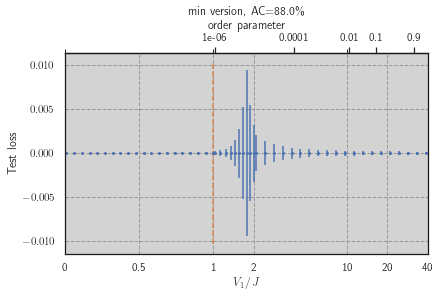

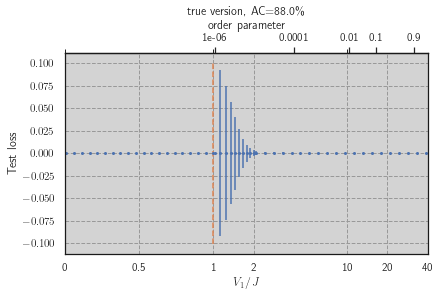

In [10]:
from utility_plots import make_RUE_plot
# Plot for real/minimal test loss and RUE (as a percentage of test loss)
print("Plotting RUE with real/minimal test loss...")
make_RUE_plot(minimal_rue, minimal_test_loss, chosen_test_examples, U_array, U_testarray, test_order_parameters, 'min_version', folder_figure, model_accuracy, LOSS_PERCENTAGE=False)
make_RUE_plot(true_rue, original_test_loss, chosen_test_examples, U_array, U_testarray, test_order_parameters, 'true_version', folder_figure, model_accuracy, LOSS_PERCENTAGE=False)

Plotting LEES for different tresholds with real/minimal test loss, neurons' outputs, and RUE...


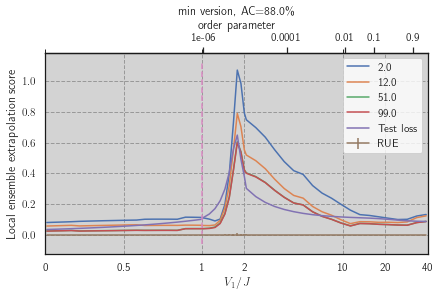

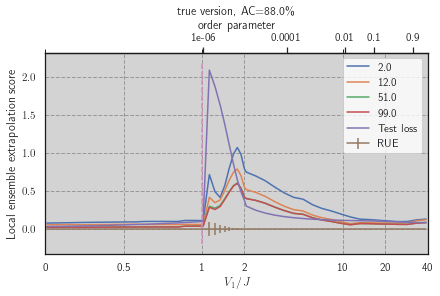

In [11]:
from utility_plots import make_LEES_plot
# Plot for various overlapped LEES + real/minimal scaled test loss + scaled neuron output + RUE (NOT as a percentage of test loss)
print("Plotting LEES for different tresholds with real/minimal test loss, neurons' outputs, and RUE...")
make_LEES_plot(various_min_lees, ms, minimal_test_loss, minimal_rue, chosen_test_examples, U_array, U_testarray, test_order_parameters, 'min_version', folder_figure, model_accuracy)
make_LEES_plot(various_true_lees, ms, original_test_loss, true_rue, chosen_test_examples, U_array, U_testarray, test_order_parameters, 'true_version', folder_figure, model_accuracy)

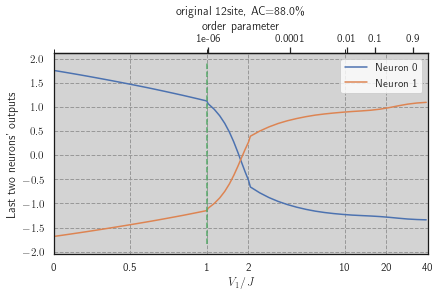

In [12]:
from utility_plots import make_neurons_outputs_plot
# Plot for neurons' outputs
make_neurons_outputs_plot([neuron_0, neuron_1], chosen_test_examples, U_array, U_testarray, test_order_parameters, "original_12site", folder_figure, model_accuracy)